In [1]:
import pandas as pd
from pathlib import Path
import torch
import sys
import numpy as np
sys.path.append('../src')

from models.ae_kan_correlation import KANAutoencoderCorrelation

data_dir = Path("../data/processed/sectors")
sectors_list = [d.name for d in data_dir.iterdir() if d.is_dir() and d.name != 'unknown']

sector_log_returns = {}
for sector in sectors_list:
    returns_path = data_dir / sector / "log_returns.csv"
    df = pd.read_csv(returns_path, index_col=0)
    sector_log_returns[sector] = df.iloc[1:]  # Skip first row with NaN values
    
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    print(f"Memory available: {torch.cuda.mem_get_info()[0] / 1024**3:.1f} GB")

print(f"Device : {device}")

GPU: NVIDIA GeForce RTX 3070 Laptop GPU
Total memory: 8.0 GB
Memory available: 6.9 GB
Device : cuda


In [2]:
for sector in sector_log_returns:
    print(sector, sector_log_returns[sector].shape[1])

communication_services 17
consumer_discretionary 43
consumer_staples 33
energy 16
financials 64
health_care 53
industrials 64
information_technology 53
materials 22
real_estate 29
utilities 29


In [3]:
# Functions

def preprocessing_dataset(
    log_returns_df: pd.DataFrame,
    win: int = 60,
    min_periods: int = 40,
    clip_val: float = 3.0,
    min_valid_per_day: int = 30,
    use_median: bool = True,
    soft_weights: bool = True,
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Prétraitement CAUSAL (dates x tickers) pour KAN/PCA.
    Retourne:
      X_df: z-score 60j -> de-mean par date -> clip [-clip_val, +clip_val]
      W_df: poids soft 0..1 (ou mask binaire en float si soft_weights=False)
      M_df: mask dur 0/1 (uint8)
    """
    df = log_returns_df.sort_index().copy()

    # 1) Rolling z-score causal (pas de center, pas d'info future)
    mu  = df.rolling(win, min_periods=min_periods).mean()
    sig = df.rolling(win, min_periods=min_periods).std(ddof=0)
    z = (df - mu) / sig

    # Mask dur: z défini ET sigma>0
    M_df = (z.notna()) & (sig.gt(0))

    # 2) De-mean cross-sectionnel (médiane robuste par défaut)
    center = z.median(axis=1) if use_median else z.mean(axis=1)
    z_dm = z.sub(center, axis=0)

    # 3) Clip dans [-clip_val, +clip_val]
    X_df = z_dm.clip(-clip_val, clip_val)

    # 4) Poids soft de fiabilité (0..1) selon taille de fenêtre disponible
    if soft_weights:
        cnt = df.rolling(win, min_periods=1).count()  # 1..win
        denom = max(1, win - min_periods)             # ex: 20 si 60/40
        rel = ((cnt - min_periods) / denom).clip(lower=0.0, upper=1.0)
        W_df = (M_df.astype(float) * rel).astype(float)
    else:
        W_df = M_df.astype(float)

    # 5) Filtrer les dates trop creuses
    keep = M_df.sum(axis=1) >= int(min_valid_per_day)
    X_df = X_df.loc[keep]
    M_df = M_df.loc[keep]
    W_df = W_df.loc[keep]

    # 6) Fill NA après avoir figé le mask/poids
    X_df = X_df.fillna(0.0)
    W_df = W_df.fillna(0.0)
    M_df = M_df.astype(np.uint8)

    return X_df, W_df, M_df


import matplotlib.pyplot as plt

def plot_training_history(history, hyperparameters):
    # Create a figure with 2 rows and 2 columns of subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Plot training and validation loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss') 
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot regularization loss
    ax2.plot(history['regularization'])
    ax2.set_title('Regularization Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.grid(True)

    # Plot skip gain evolution
    ax3.plot(history['skip_gain'])
    ax3.set_title('Skip Gain Evolution')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Skip Gain')
    ax3.grid(True)

    # Plot skip weight norm
    ax4.plot(history['skip_weight_norm'])
    ax4.set_title('Skip Weight Norm')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Weight Norm')
    ax4.grid(True)

    plt.tight_layout()
    plt.show()
    
    # Add hyperparameters as text on the figure
    hyperparams_text = "\n".join([
        f"{k}: {v}" for k, v in hyperparameters.items()
    ])
    
    # Add text box with hyperparameters
    fig.text(1.02, 0.5, hyperparams_text, 
             bbox=dict(facecolor='white', alpha=0.8),
             fontsize=8, 
             transform=plt.gcf().transFigure,
             verticalalignment='center')
    
    plt.subplots_adjust(right=0.85)
    from datetime import datetime
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    fig.savefig(f'../figures/training_history_{timestamp}.png',
                bbox_inches='tight', 
                dpi=300)
    
    
def generate_grid_for_sector(X_df, sector):
    hyperparameters_grid = {
    'input_dim': X_df[sector].shape[1],
    'hidden_dims_choices': [
        [128, 64],
        [256, 128, 64], 
        [512, 256, 128, 64]
    ],
    'latent_dims': [8, 16, 32], # bottleneck

    # Architecture KAN
    'basis_types': ["spline", "poly"],
    'M_values': [8, 16, 32],
    'poly_degrees': [3, 5, 7],

    # Activation et régularisation
    'use_silu_choices': [True, False],  # SiLU vs Identity
    'dropout_rates': [0.0, 0.1, 0.2],

    # Skip connections
    'use_global_skip': [True, False],
    'use_skip_choices': [True, False],  # Skip par couche
    'skip_init_choices': ["zeros", "identity", "xavier"],
    'skip_gain_values': [0.1, 0.5, 1.0],

    # Régularisations
    'lambda_reg_values': [0.0, 1e-4, 1e-3],
    'lambda_alpha_values': [0.0, 1e-4, 1e-3],  # L1 sur alpha
    'lambda_group_values': [0.0, 1e-5, 1e-4],  # Group lasso sur c
    'lambda_tv_values': [0.0, 1e-4, 1e-3],  # Total variation sur c (splines)
    'lambda_poly_decay_values': [0.0, 0.1, 1.0],  # Décroissance polynomiale (poly)
    'lambda_skip_l2_values': [0.0, 1e-3, 1e-2],  # L2 sur skip

    # Loss
    'loss_types': ["mse", "huber"], 
    'huber_deltas': [0.1, 0.5, 1.0],

    # Optimisation du training
    'learning_rates': [1e-4, 5e-4, 1e-3],
    'weight_decays': [1e-5, 1e-4],
    'batch_sizes': [32, 64, 128, 256]
}
    return hyperparameters_grid


def sample_and_train(hyperparameters_grid, X_train, X_test, device='cuda', epochs=100):
    import random
    
    sampled_params = {}
    for param_name, param_values in hyperparameters_grid.items():
        if isinstance(param_values, list):
            sampled_params[param_name] = random.choice(param_values)
        else:
            sampled_params[param_name] = param_values
            
    return sampled_params

def evaluate_model(model, X_test, device):
    model.eval()
    with torch.no_grad():
        X_test_recon = model(X_test)
        test_loss = model.loss_fn(X_test_recon, X_test).item()
        print(f"Test loss: {test_loss:.4f}")
        
        
def train_kan_model(hyperparameters, X_train, X_test, device='cuda', epochs=100):
    # Convert device string to torch.device
    device = torch.device(device)
    
    # Move data to device
    X_train = X_train.to(device)
    X_test = X_test.to(device)
    
    model = KANAutoencoder(
        input_dim=hyperparameters['input_dim'],
        hidden_dims=hyperparameters['hidden_dims_choices'],
        k=hyperparameters['latent_dims'],
        basis_type=hyperparameters['basis_types'],
        M=hyperparameters['M_values'],
        poly_degree=hyperparameters['poly_degrees'],
        use_silu=hyperparameters['use_silu_choices'],
        dropout_p=hyperparameters['dropout_rates'],
        use_global_skip=hyperparameters['use_global_skip'],
        use_skip=hyperparameters['use_skip_choices'],
        skip_init=hyperparameters['skip_init_choices'],
        skip_gain=hyperparameters['skip_gain_values'],
        lambda_alpha=hyperparameters['lambda_alpha_values'],
        lambda_group=hyperparameters['lambda_group_values'],
        lambda_tv=hyperparameters['lambda_tv_values'],
        lambda_poly_decay=hyperparameters['lambda_poly_decay_values'],
        lambda_skip_l2=hyperparameters['lambda_skip_l2_values'],
        loss_type=hyperparameters['loss_types'],
        huber_delta=hyperparameters['huber_deltas']
        
    ).to(device)
    
    history = model.fit(X_train,
            epochs=epochs,
            batch_size=hyperparameters['batch_sizes'],
            learning_rate=hyperparameters['learning_rates'],
            weight_decay=hyperparameters['weight_decays'],
            validation_split=0.2,
            patience=15,
            verbose=True,
            lambda_reg=hyperparameters['lambda_reg_values'],
            device=device
            )
    plot_training_history(history, hyperparameters)
    print(f"Training time: {history['training_time']:.2f} seconds")
    evaluate_model(model, X_test, device)

In [4]:
# Generate datasets 

X_df = {}
W_df = {}
M_df = {}

for sector in sector_log_returns:
    X_df[sector], W_df[sector], M_df[sector] = preprocessing_dataset(
        log_returns_df=sector_log_returns[sector],
        win=60,
        min_periods=40,
        clip_val=3.0,
        min_valid_per_day=5,
        use_median=True,
        soft_weights=True
    )

In [5]:
# Generate X_sector, W_sector and M_sector

chosen_sector = "information_technology"
X_sector = X_df[chosen_sector]
W_sector = W_df[chosen_sector] 
M_sector = M_df[chosen_sector]

print(f"Secteur choisi: {chosen_sector}")
print(f"Dimensions: {X_df[chosen_sector].shape}")
print(f"Période: {X_df[chosen_sector].index[0]} à {X_df[chosen_sector].index[-1]}")
print("\nStatistiques des données:")
print(f"Moyenne: {X_sector.mean().mean():.4f}")
print(f"Écart-type: {X_sector.std().mean():.4f}")
print(f"Taux de valeurs valides: {M_sector.mean().mean():.2%}")


# Passer en tensor et Train/Test

X_tensor = torch.tensor(X_sector.values, dtype=torch.float32)
W_tensor = torch.tensor(W_sector.values, dtype=torch.float32)
M_tensor = torch.tensor(M_sector.values, dtype=torch.float32)

train_size = int(0.8 * len(X_tensor))
X_train = X_tensor[:train_size]
X_test = X_tensor[train_size:]

W_train = W_tensor[:train_size]
W_test = W_tensor[train_size:]

M_train = M_tensor[:train_size]
M_test = M_tensor[train_size:]

print(f"Train: {X_train.shape[0]} échantillons")
print(f"Test: {X_test.shape[0]} échantillons")
print(f"Dates train: {X_sector.index[0]} à {X_sector.index[train_size-1]}")
print(f"Dates test: {X_sector.index[train_size]} à {X_sector.index[-1]}")


Secteur choisi: information_technology
Dimensions: (3734, 53)
Période: 2010-03-03 à 2024-12-31

Statistiques des données:
Moyenne: 0.0060
Écart-type: 0.7041
Taux de valeurs valides: 100.00%
Train: 2987 échantillons
Test: 747 échantillons
Dates train: 2010-03-03 à 2022-01-10
Dates test: 2022-01-11 à 2024-12-31


# Parameters definition (1 training)

In [15]:
# ONE TRAINING 

input_dim = X_train.shape[1]
latent_dim = 16
hidden_dims = [32, 16]


epochs = 200
batch_size = 128
learning_rate = 0.0001
weight_decay = 0.00001
validation_split = 0.2
patience = 15
verbose = True

# Basis
basis_type = "spline"
M_value = 16
poly_degree = 5
use_silu = True
xmin = -3.5
xmax = 3.5
dropout_p = 0



# LOSS
loss_type = "cosine"    # "mse" | "huber" | "correlation" | "cosine" | "corr_mse_mix"
huber_delta = 1.0
alpha = 0.5
beta = 0.5

# REGULARISATIONS
lambda_reg = 1.0
lambda_alpha = 1e-5
lambda_group = 1e-5
lambda_tv = 1e-5
lambda_poly_decay = 0.0
lambda_skip_l2 = 1e-5

# SKIP
use_global_skip = False

use_skip = False
skip_init = "zeros"
skip_gain = 0

In [10]:
config = {
    'input_dim': input_dim,
    'latent_dim': latent_dim,
    'hidden_dims': hidden_dims,
    'epochs': epochs,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'weight_decay': weight_decay,
    'validation_split': validation_split,
    'patience': patience,
    'verbose': verbose,
    'basis_type': basis_type,
    'M_value': M_value,
    'poly_degree': poly_degree,
    'use_silu': use_silu,
    'xmin': xmin,
    'xmax': xmax,
    'dropout_p': dropout_p,
    'loss_type': loss_type,
    'huber_delta': huber_delta,
    'lambda_reg': lambda_reg,
    'lambda_alpha': lambda_alpha,
    'lambda_group': lambda_group,
    'lambda_tv': lambda_tv,
    'lambda_poly_decay': lambda_poly_decay,
    'lambda_skip_l2': lambda_skip_l2,
    'use_global_skip': use_global_skip,
    'use_skip': use_skip,
    'skip_init': skip_init,
    'skip_gain': skip_gain
}

# KAN Model (1 training)

In [16]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device utilisé: {device}")

kan = KANAutoencoderCorrelation(
    input_dim=input_dim,
    k=latent_dim,
    hidden_dims = hidden_dims,
    basis_type = "spline",
    M = M_value,
    poly_degree = poly_degree,
    xmin = xmin,
    xmax = xmax,
    dropout_p = dropout_p,
    use_silu = use_silu,
    
    # LOSS
    loss_type= loss_type,  
    huber_delta= huber_delta,
    alpha = alpha,
    beta = beta,
    
    # régularisations KAN
    lambda_alpha = lambda_alpha,
    lambda_group = lambda_group,
    lambda_tv = lambda_tv,
    lambda_poly_decay = lambda_poly_decay,
    lambda_skip_l2 = lambda_skip_l2,
    
    # SKIP LINEAIRE
    use_global_skip = use_global_skip,
    use_skip = use_skip,
    skip_init = skip_init,
    skip_gain = skip_gain
)

kan.to(device)

print(f"Nombre total de paramètres: {sum(p.numel() for p in kan.parameters()):,}")
print("Architecture:")
print(f"{input_dim} → {' → '.join(map(str, hidden_dims))} → Latent ({latent_dim}) → {' → '.join(map(str, hidden_dims))} → {input_dim}")

Device utilisé: cuda
Nombre total de paramètres: 75,749
Architecture:
53 → 32 → 16 → Latent (16) → 32 → 16 → 53


In [17]:
history = kan.fit(
    X_train,
    epochs=epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    validation_split=validation_split,
    patience=patience,
    verbose=verbose,
    lambda_reg=lambda_reg
)

📈 Epoch 1/200 | Train: 1.001973 | Val: 0.999833 ✅ | Reg: 0.008740 | LR: 1.00e-04
📈 Epoch 2/200 | Train: 1.000101 | Val: 1.002717 ❌ | Reg: 0.006960 | LR: 1.00e-04
📈 Epoch 3/200 | Train: 1.001479 | Val: 1.002843 ❌ | Reg: 0.005457 | LR: 1.00e-04
📈 Epoch 4/200 | Train: 1.001394 | Val: 1.005361 ❌ | Reg: 0.004212 | LR: 1.00e-04
📈 Epoch 5/200 | Train: 1.002680 | Val: 1.006650 ❌ | Reg: 0.003198 | LR: 1.00e-04
📈 Epoch 6/200 | Train: 1.002109 | Val: 1.006650 ❌ | Reg: 0.002407 | LR: 1.00e-04
📈 Epoch 7/200 | Train: 1.000766 | Val: 1.005972 ✅ | Reg: 0.001825 | LR: 1.00e-04
📈 Epoch 8/200 | Train: 1.001878 | Val: 1.005741 ✅ | Reg: 0.001375 | LR: 1.00e-04
📈 Epoch 9/200 | Train: 1.002480 | Val: 1.008660 ❌ | Reg: 0.001031 | LR: 5.00e-05
📈 Epoch 10/200 | Train: 1.001751 | Val: 1.008660 ❌ | Reg: 0.000817 | LR: 5.00e-05
📈 Epoch 11/200 | Train: 1.001562 | Val: 1.008660 ❌ | Reg: 0.000698 | LR: 5.00e-05
📈 Epoch 12/200 | Train: 1.001888 | Val: 1.008660 ❌ | Reg: 0.000596 | LR: 5.00e-05
📈 Epoch 13/200 | Train: 1

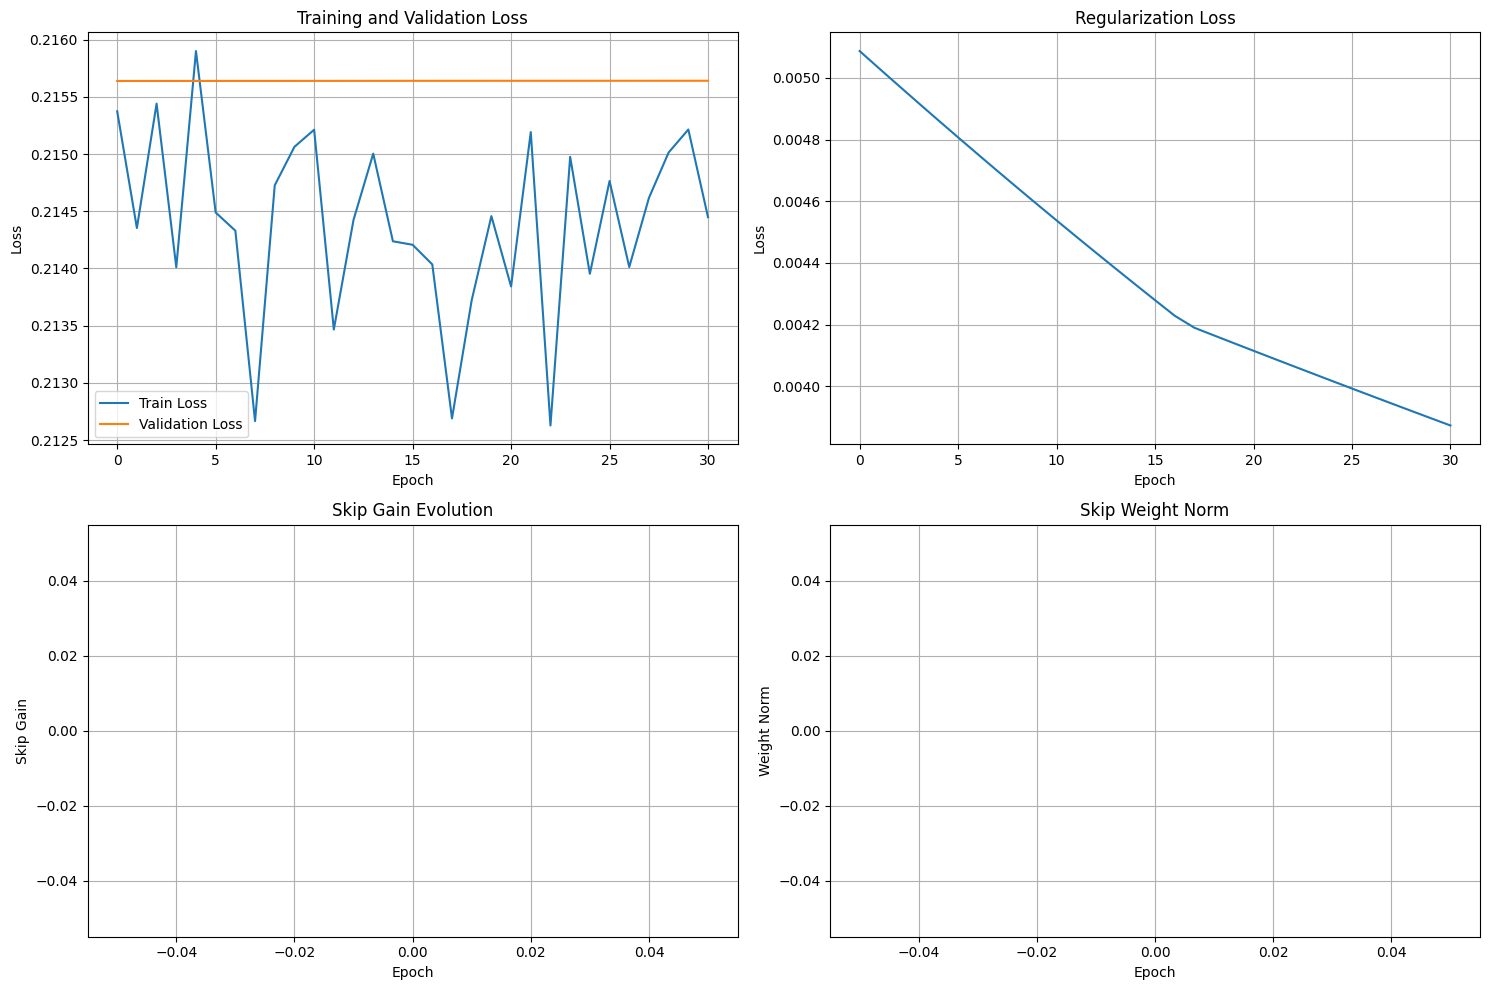

<Figure size 640x480 with 0 Axes>

In [16]:
plot_training_history(history, config)

In [17]:
def create_kan_model(config, input_dim):
    """Crée un modèle KAN avec la configuration donnée"""
    from models.ae_kan import KANAutoencoder
    
    return KANAutoencoder(
        input_dim=input_dim,
        k=config['latent_dim'],
        hidden_dims=config['hidden_dims'],
        basis_type=config['basis_type'],
        M=config['M_value'],
        poly_degree=config['poly_degree'],
        xmin=config['xmin'],
        xmax=config['xmax'],
        dropout_p=config['dropout_p'],
        use_silu=config['use_silu'],
        
        # LOSS
        loss_type=config['loss_type'],
        huber_delta=config['huber_delta'],
        
        # Régularisations KAN
        lambda_alpha=config['lambda_alpha'],
        lambda_group=config['lambda_group'],
        lambda_tv=config['lambda_tv'],
        lambda_poly_decay=config['lambda_poly_decay'],
        lambda_skip_l2=config['lambda_skip_l2'],
        
        # Skip connections
        use_global_skip=config['use_global_skip'],
        use_skip=config['use_skip'],
        skip_init=config['skip_init'],
        skip_gain=config['skip_gain']
    )

def train_kan_model(model, X_train, training_config, device="cuda", model_name="model"):
    
    history = model.fit(
        X_train,
        batch_size=training_config['batch_size'],
        epochs=training_config['epochs'],
        learning_rate=training_config['learning_rate'],
        weight_decay=training_config['weight_decay'],
        lambda_reg=training_config['lambda_reg'],
        patience=training_config['patience'],
        model_path=f'results/grid_search_{model_name}.pth'
    )
    
    return {
        'history': history,
        'best_val_loss': min(history['val_loss']),
        'final_train_loss': history['train_loss'][-1],
        'final_val_loss': history['val_loss'][-1],
        'epochs_trained': len(history['train_loss']),
        'training_time': history['training_time']
    }

# def evaluate_model(model, X_test, W_test, device):
#     """Évalue un modèle sur l'ensemble de test"""
#     model.eval()
    
#     with torch.no_grad():
#         X_test_reconstructed, latent_test = model(X_test)
        
#         # Conversion en numpy
#         X_test_np = X_test.cpu().numpy()
#         X_test_recon_np = X_test_reconstructed.cpu().numpy()
#         W_test_np = W_test.cpu().numpy()
        
#         # Métriques pondérées
#         mse_weighted = np.sum(W_test_np * (X_test_np - X_test_recon_np)**2) / np.sum(W_test_np)
#         mae_weighted = np.sum(W_test_np * np.abs(X_test_np - X_test_recon_np)) / np.sum(W_test_np)
        
#         return {
#             'mse_weighted': mse_weighted,
#             'mae_weighted': mae_weighted,
#             'rmse_weighted': np.sqrt(mse_weighted),
#             'reconstruction_error': np.mean((X_test_np - X_test_recon_np)**2)
#         }

In [19]:
kan = create_kan_model(config, input_dim)
train_kan_model(kan, X_train, config)

TypeError: KANAutoencoder.fit() got an unexpected keyword argument 'model_path'